# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: HTR with User Data 

In [1]:
pip list | grep spot

pyspot                                    0.0.1
pyspotriver                               0.0.3
pyspotstream                              0.2.0
spotPython                                0.0.11
spotRiver                                 0.0.13
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall http://www.gm.fh-koeln.de/~bartz/site/spotPython.tar.gz

## Example 1: HTR Hyperparameter

In [3]:
import numpy as np
from math import inf
from spotRiver.fun.hyperriver import HyperRiver
from spotPython.spot import spot
from spotRiver import data
from scipy.optimize import shgo
from scipy.optimize import direct
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from spotRiver.utils.selectors import select_leaf_prediction
from spotRiver.utils.selectors import select_leaf_model

### 1 The Objective Function 

* Here we will use the river `HATR` function.
* First, the function will be tested independently from `Spot`.

In [4]:
import numpy as np
import datetime as dt
from river import datasets
from river import time_series
from river import utils
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import metrics
from spotRiver.fun.hyperriver import HyperRiver

* Note: Instead of using the Airline Passenger data as in notebook 01, we demonstrate the usage of user specified data which is *not* part of the `spotRiver` package!

## River's Synth Data Example

In [5]:
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree

In [6]:
from river.datasets import synth
n_samples = 10_000
data = synth.Friedman(seed=42).take(n_samples)
dataset  = list(data)

In [7]:
# from spotRiver.data.generic import GenericData
# fraction = 1.0
# data = GenericData(filename="opm_num.zip",
#                       directory=".",
#                       target="Sale Amount",
#                       n_features=7,
#                       n_samples=985_862,
#                       fraction = fraction,
#                       converters={'List Year': int,
#                                   'Assessed Value': float,
#                                   'Sale Amount': float,
#                                   'Sales Ratio': float,
#                                   'lon': float,
#                                   'lat': float,
#                                   'timestamp_rec': float},
#                       parse_dates=None
#                       # parse_dates={"Date Recorded": "%Y-%m-%d"}
#                       )
# n_samples = int(data.n_samples * fraction)
# dataset = list(data)

In [8]:
for x,y in dataset:
    print(x,y)
    break

{0: 0.6394267984578837, 1: 0.025010755222666936, 2: 0.27502931836911926, 3: 0.22321073814882275, 4: 0.7364712141640124, 5: 0.6766994874229113, 6: 0.8921795677048454, 7: 0.08693883262941615, 8: 0.4219218196852704, 9: 0.029797219438070344} 7.6612066799391085


In [9]:
fun = HyperRiver(seed=123, log_level=20).fun_HTR_iter_progressive
var_type = ["int"] * 2 + ["num"] * 2 + ["factor"] * 2 + ["num"] + ["int"] * 2 + ["factor"] + ["num"]
var_type

['int',
 'int',
 'num',
 'num',
 'factor',
 'factor',
 'num',
 'int',
 'int',
 'factor',
 'num']

In [10]:
var_name=["gracePeriod", "maxDepth", "delta", "tau", "leafPrediction",
          "leafModel", "modelSelDecay", "splitter",
          "minSamplesSplit", "binarySplit", "maxSize"]

grace_period 199
max_depth 10
delta 3.422368745191023e-07
tau 0.03481562818930133
leaf_prediction mean
leaf_model Perceptron
model_selector_decay 1.0
splitter QOSplitter
min_samples_split 5
binary_split 1
max_size 412.0
Eval iter_prog_val_score: [##########] 100.00% Done...
grace_period 194
max_depth 100000
delta 3.6154970089883783e-07
tau 0.03917575840390259
leaf_prediction mean
leaf_model LinearRegression
model_selector_decay 1.0
splitter QOSplitter
min_samples_split 7
binary_split 1
max_size 298.0

In [11]:
# [[2.00e+02 1.00e+01 1.00e-06 7.50e-02 2.00e+00 1.00e+00 0.00e+00 7.00e+00 0.00e+00 3.12e+02]]
# lower = np.array([100, 1,  1e-8, 0.025, 0, 0, 0.8,  0,  5, 0, 250.0])
# upper = np.array([200, 10, 1e-6, 0.075, 1, 1, 0.975, 1, 10, 1, 750.0])

lower = np.array([100, 1,  1e-8, 0.025, 0, 0, 0.8,   0,  5, 0, 250.0])
upper = np.array([200, 6,  1e-6, 0.075, 2, 1, 0.975, 1, 10, 1, 750.0])
fun_control = {"data": dataset,
               "n_samples": n_samples,
               "weights": np.array([1, 1/10, 1/10])*10_000.0,
               "step": 100,
               "verbosity": 2,
               "log_level": 20}

### 3 Run the `Spot` Optimizer

* Since the data is larger than the airline passengers data, the max. time is increased.

In [12]:
spot_htr = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 5,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type=var_type,
                   var_name=var_name,
                   infill_criterion = "ei",
                   n_points = 1,
                   seed=123,
                   log_level = 10,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 20,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": 11,
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 1000,
                                      "log_level": 20
                                      })
spot_htr.run()

Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_

### 4 Results

* Show the Progress

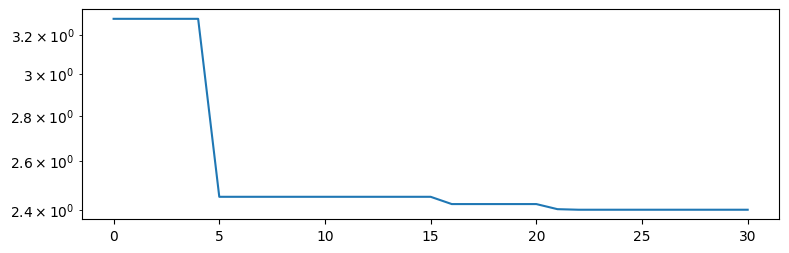

In [13]:
spot_htr.plot_progress(log_y=True)



* Print the Results

In [14]:
spot_htr.print_results()

min y: 2.399121188655137
gracePeriod: 200.0
maxDepth: 1.0
delta: 1e-08
tau: 0.025
leafPrediction: 1.0
leafModel: 0.0
modelSelDecay: 0.975
splitter: 1.0
minSamplesSplit: 5.0
binarySplit: 0.0
maxSize: 250.0


In [15]:
spot_htr.print_importance()

Importance relative to the most important parameter:
gracePeriod:  2.5324205475765532e-05
maxDepth:  1.2425315911368127e-05
delta:  1.2513301054484019e-05
tau:  1.184608994827774e-05
leafPrediction:  83.81651348692051
leafModel:  100.0
modelSelDecay:  1.2948942165609941e-05
splitter:  0.0005523778426397278
minSamplesSplit:  1.2568832812288786e-05
binarySplit:  2.6931715689733433e-05
maxSize:  1.3140507633853147e-05


## Build and Evaluate HTR Model with Tuned Hyperparameters

In [16]:
X = spot_htr.to_all_dim(spot_htr.min_X.reshape(1,-1))
print(X)
grace_period = X[:, 0]
max_depth = X[:, 1]
delta = X[:, 2]
tau = X[:, 3]
leaf_prediction = X[:, 4]
leaf_model = X[:, 5]
model_selector_decay = X[:, 6]
splitter = X[:, 7]
min_samples_split = X[:, 8]
binary_split = X[:, 9]
max_size = X[:, 10]


[[2.00e+02 1.00e+00 1.00e-08 2.50e-02 1.00e+00 0.00e+00 9.75e-01 1.00e+00
  5.00e+00 0.00e+00 2.50e+02]]


In [17]:
import numbers
from river import tree
from spotRiver.evaluation.eval_oml import fun_eval_oml_iter_progressive
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive
from spotRiver.utils.selectors import select_splitter
from spotRiver.utils.selectors import select_max_depth
num = compose.SelectType(numbers.Number) | preprocessing.StandardScaler()
cat = compose.SelectType(str) | preprocessing.FeatureHasher(n_features=1000, seed=1)
res = eval_oml_iter_progressive(
    dataset=fun_control["data"],
    step=fun_control["step"],
    log_level=20,
    metric=metrics.MAE(),
    models={
         "Default: HTR + QO": (
             (num + cat) | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),
        "SPOT: HTR + QO": (
            (num + cat) | tree.HoeffdingTreeRegressor(
                grace_period=int(grace_period),
                max_depth=select_max_depth(int(max_depth)),
                delta=float(delta),
                tau=float(tau),
                leaf_prediction=select_leaf_prediction(int(leaf_prediction)),
                leaf_model=select_leaf_model(int(leaf_model)),
                splitter=select_splitter(int(splitter)),
                min_samples_split=int(min_samples_split),
                binary_split=int(binary_split),
                max_size=float(max_size)
            )
        ),
    }
)
y = fun_eval_oml_iter_progressive(res, metric=None)

Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...


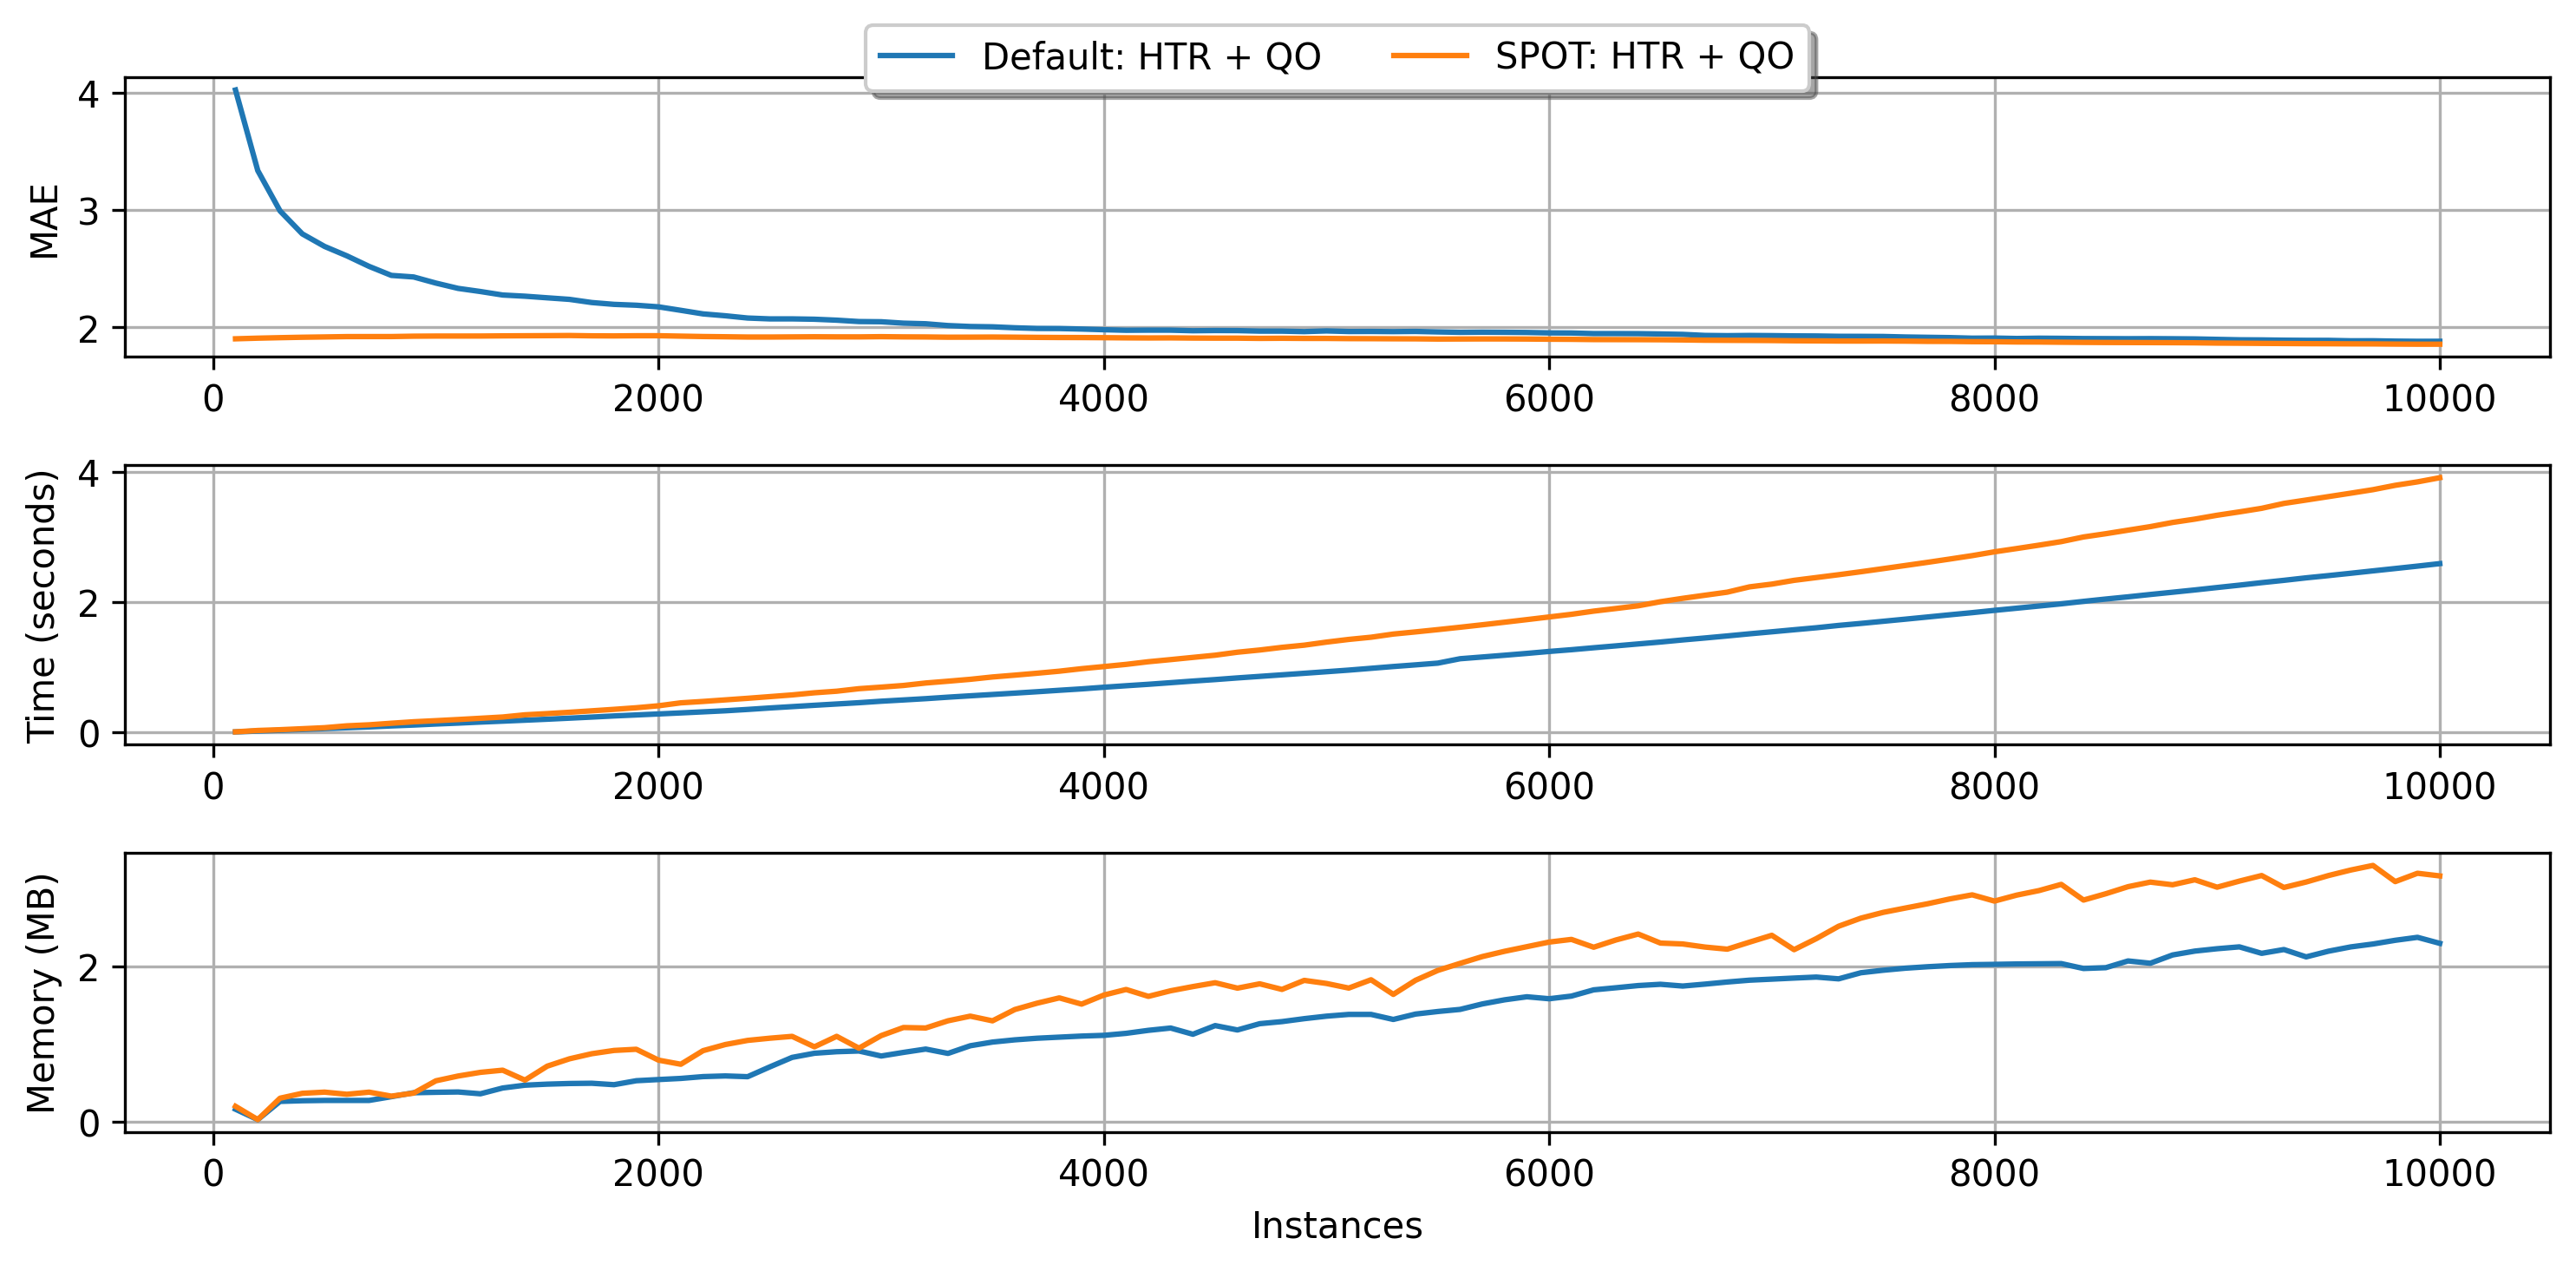

In [18]:
from spotRiver.evaluation.eval_oml import plot_oml_iter_progressive
plot_oml_iter_progressive(res, log_y=False)

In [19]:
min(spot_htr.y), max(spot_htr.y)/4

(2.399121188655137, 3.6164949939877027)

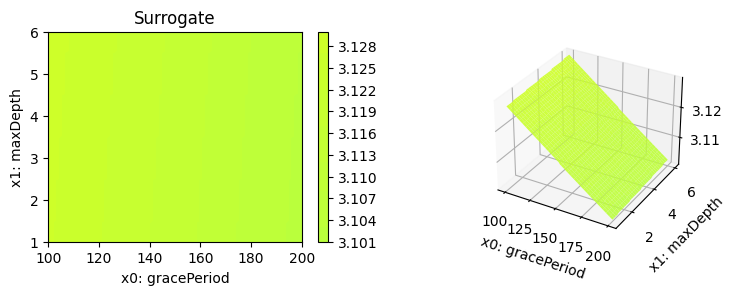

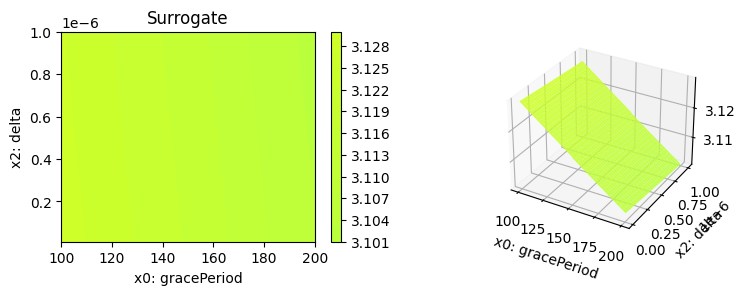

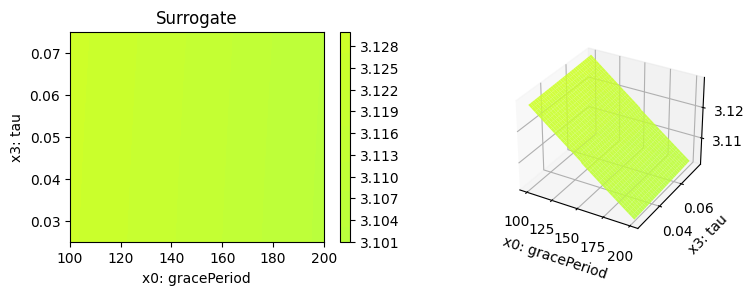

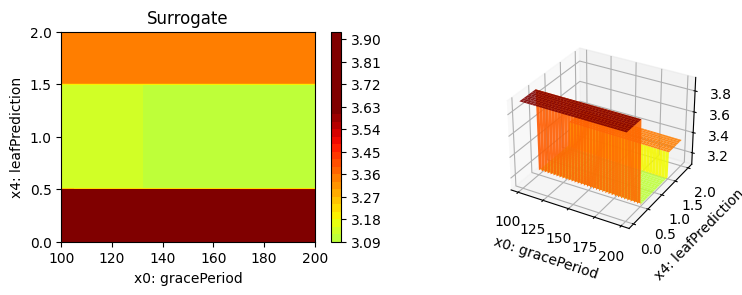

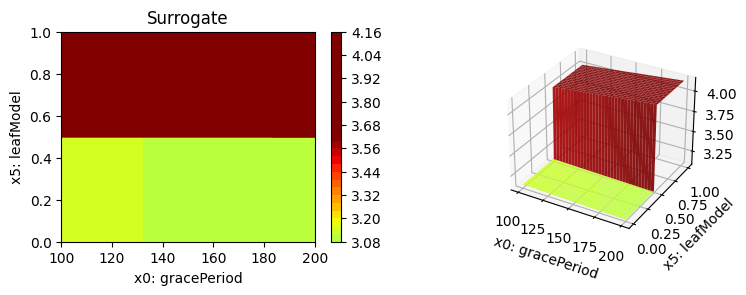

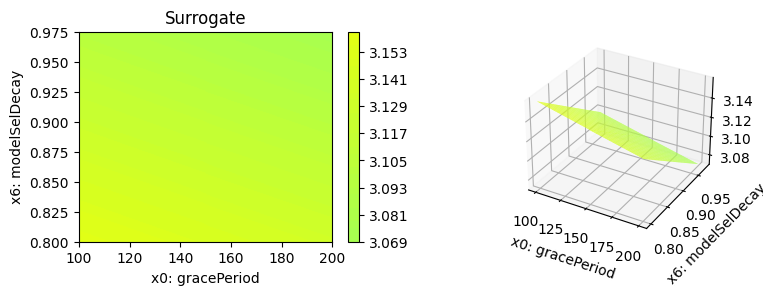

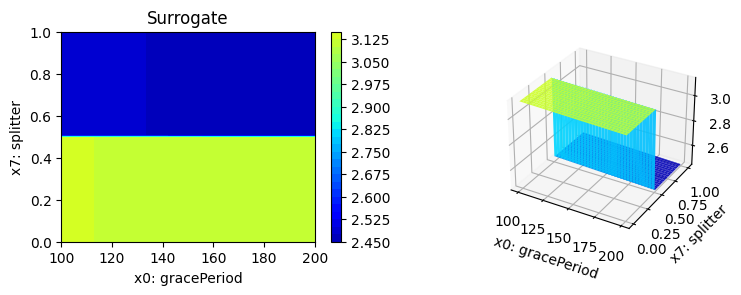

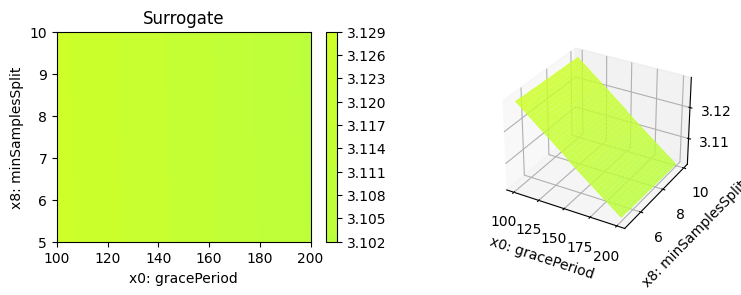

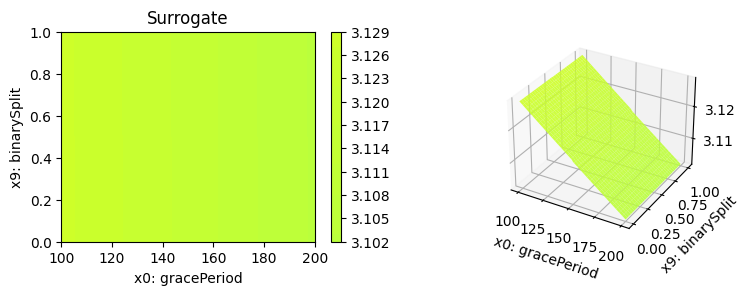

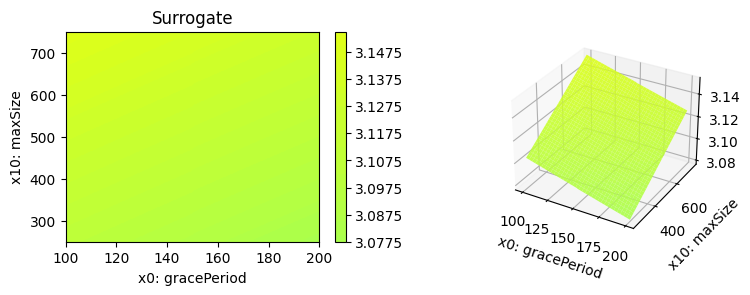

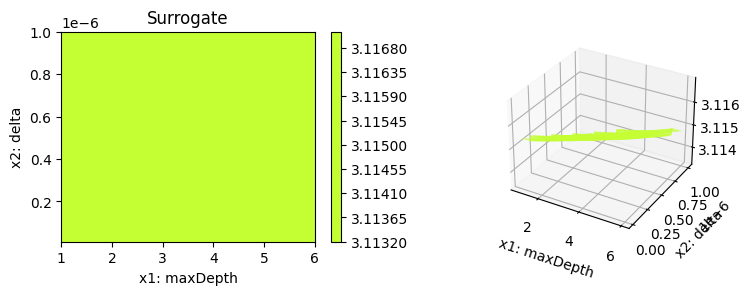

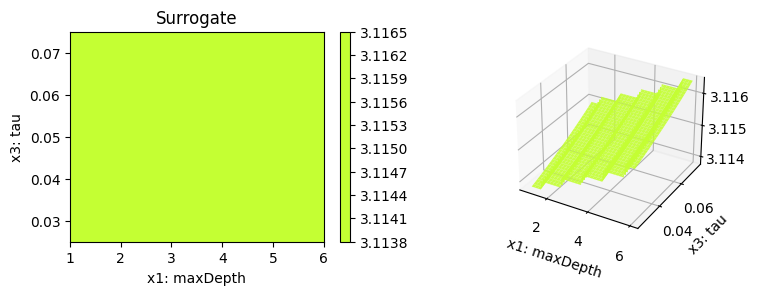

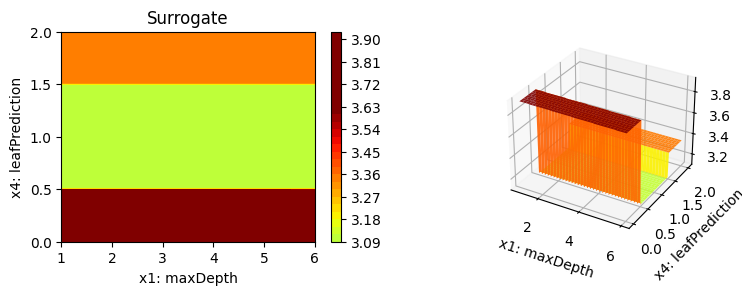

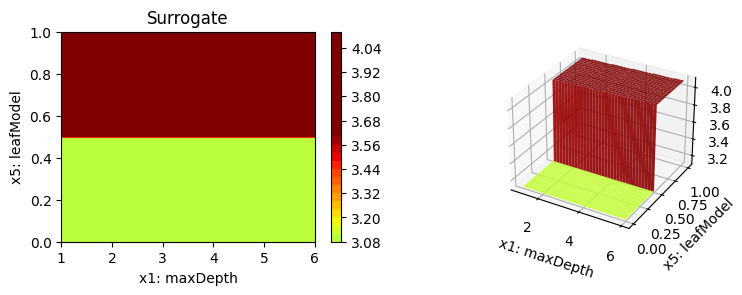

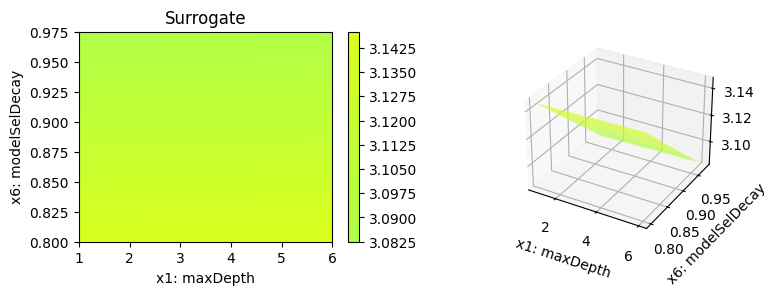

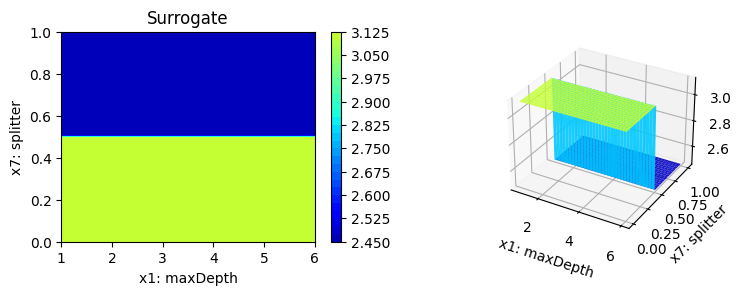

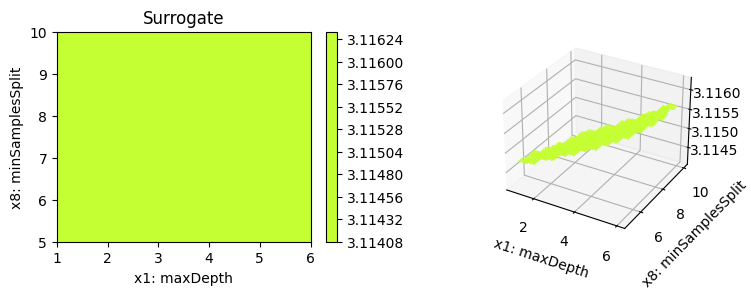

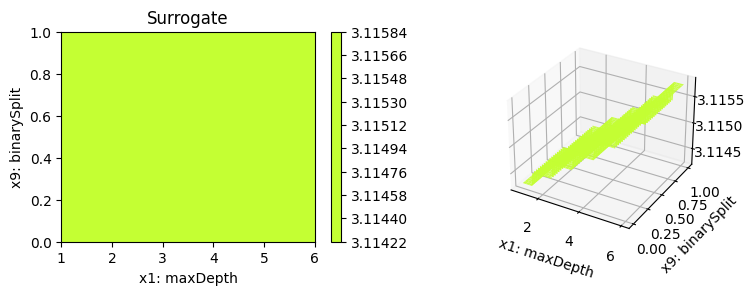

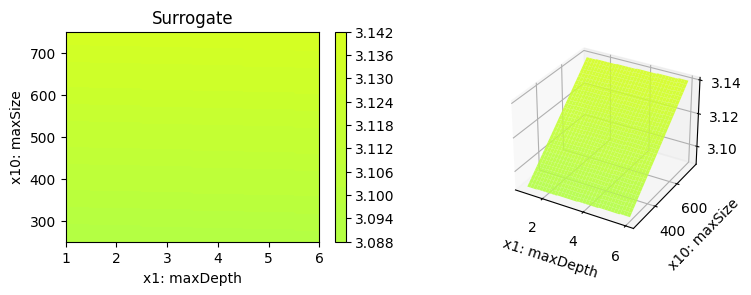

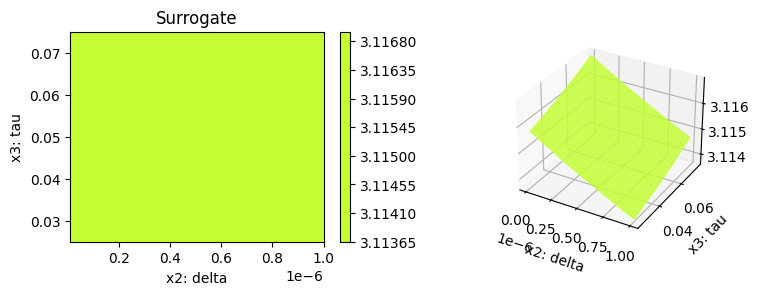

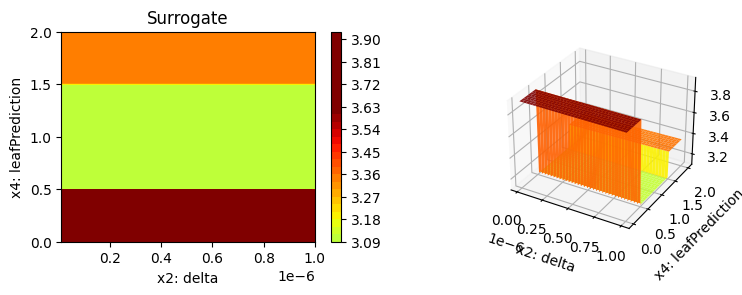

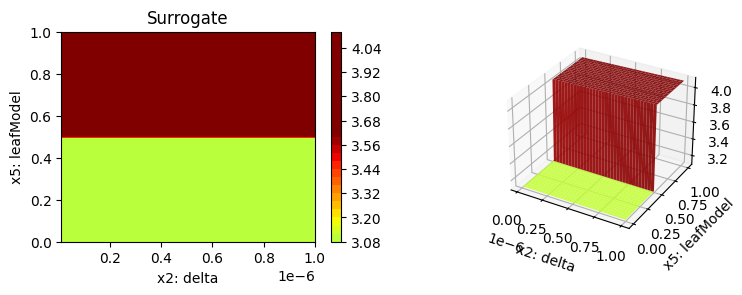

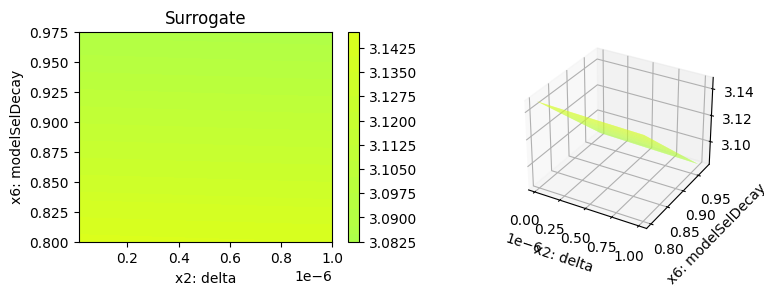

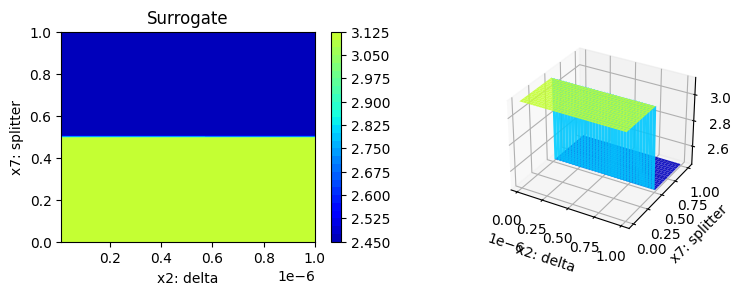

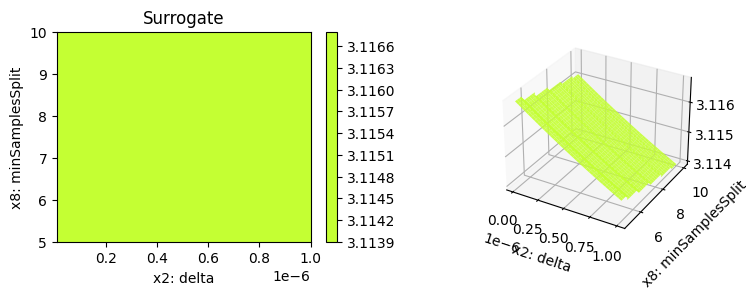

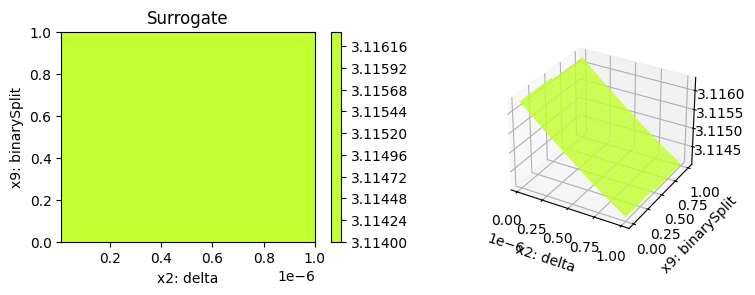

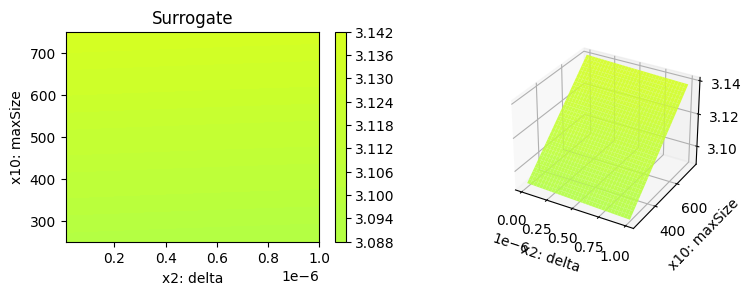

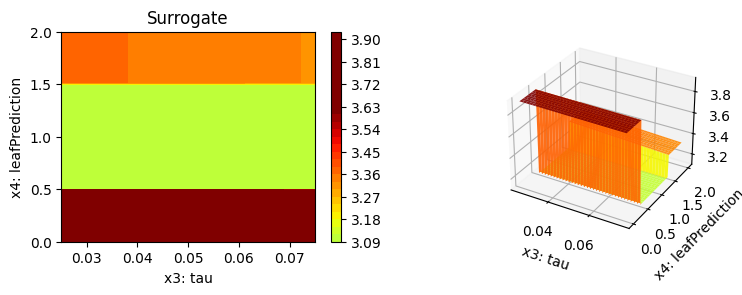

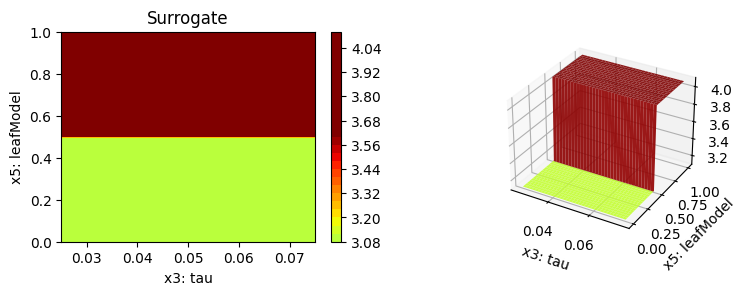

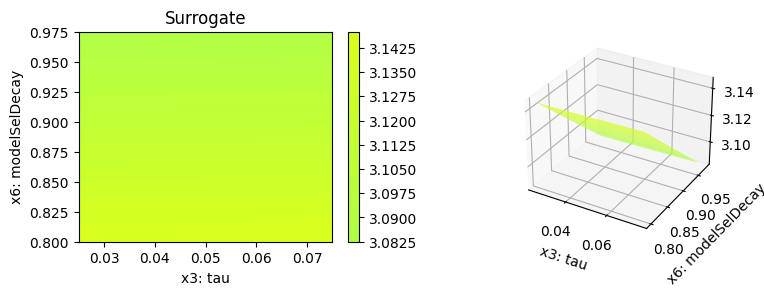

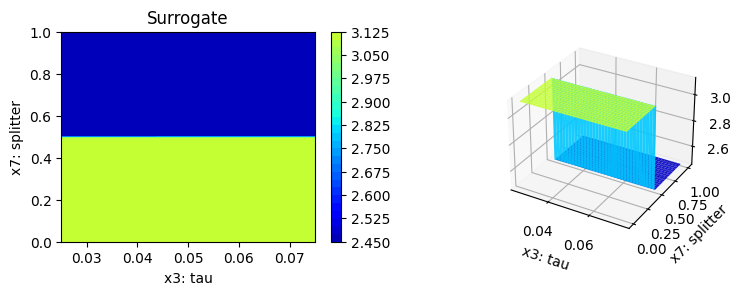

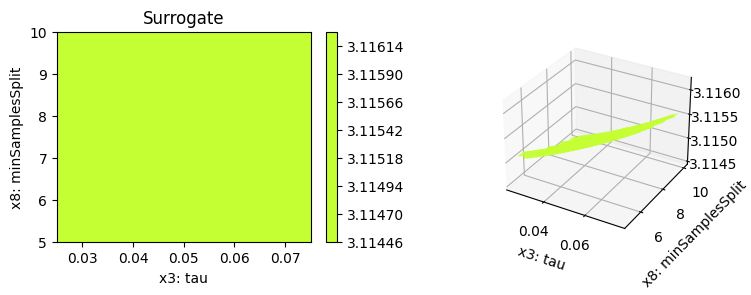

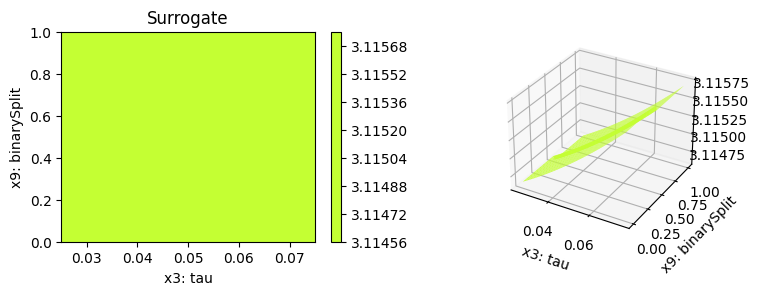

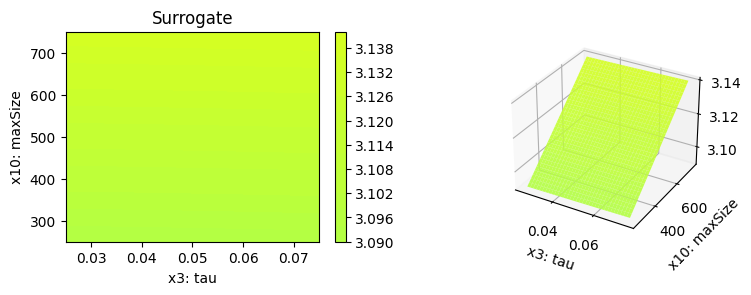

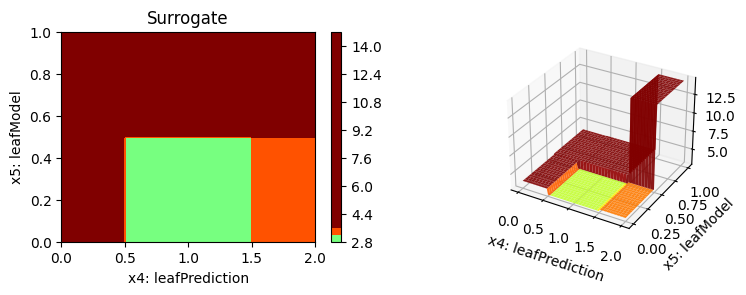

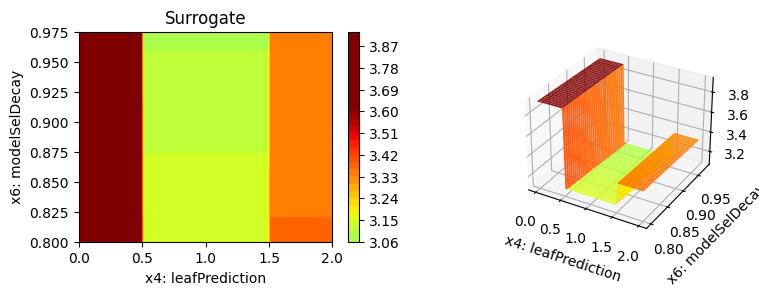

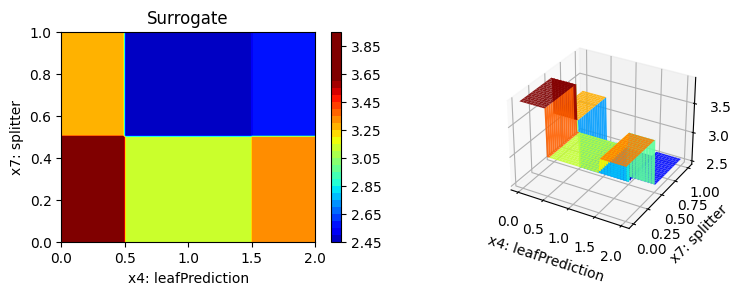

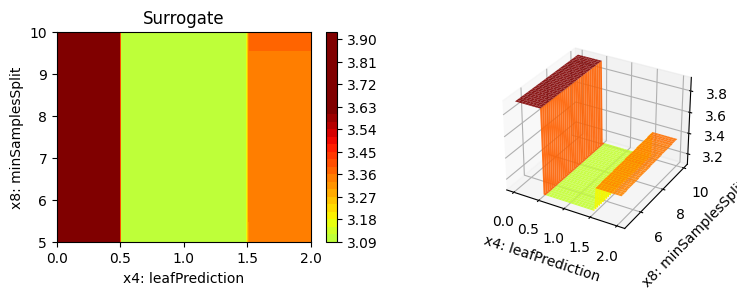

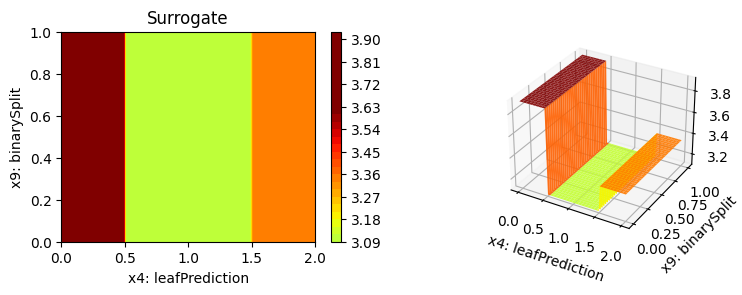

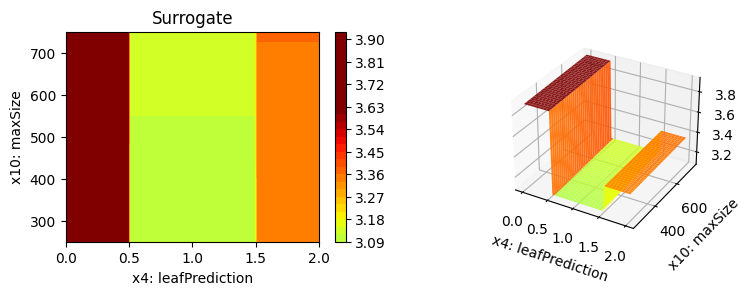

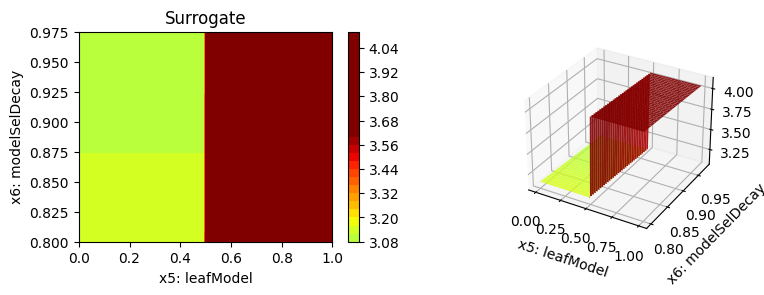

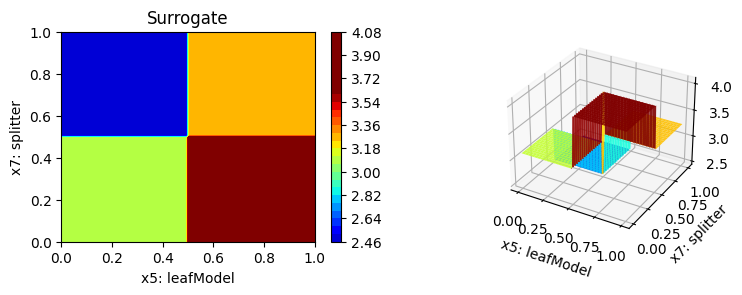

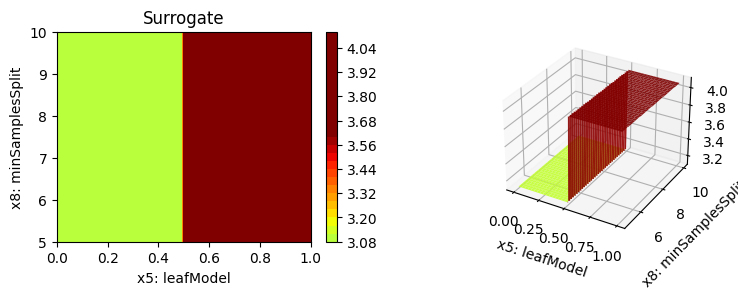

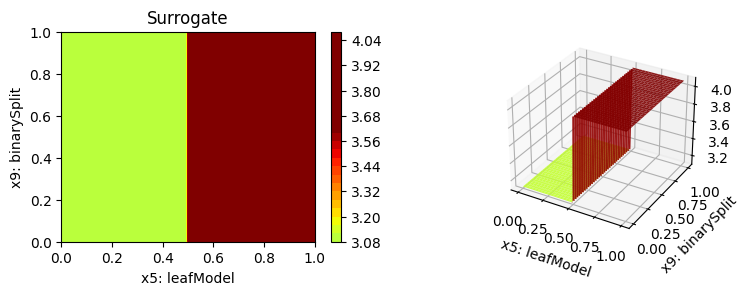

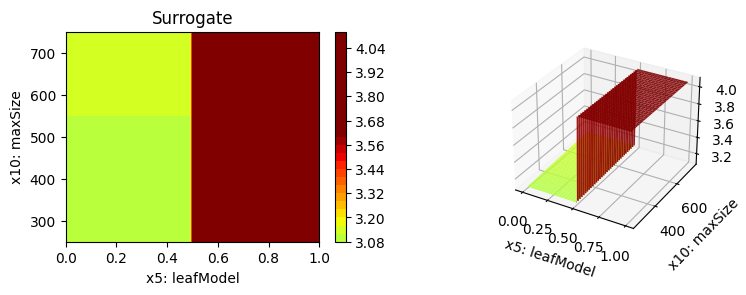

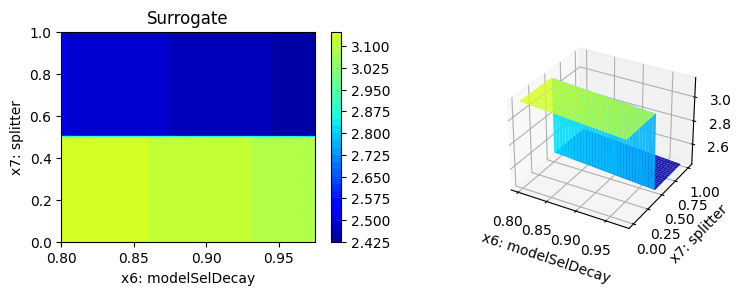

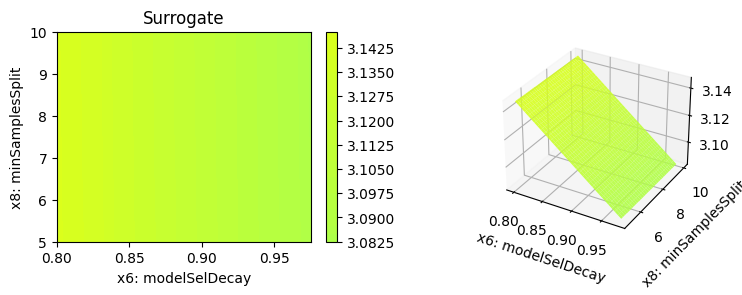

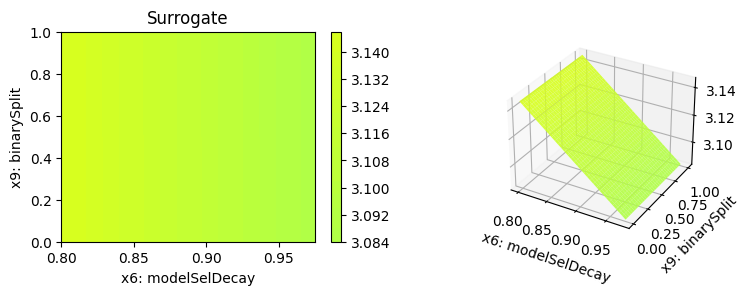

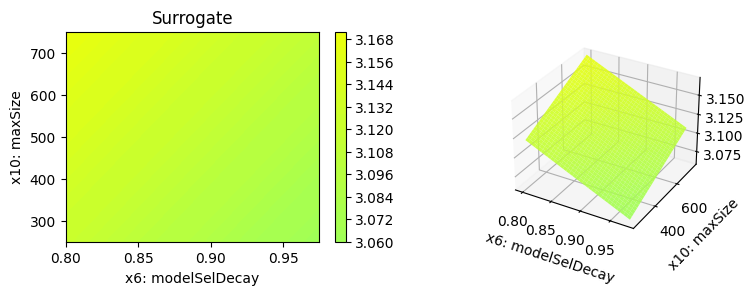

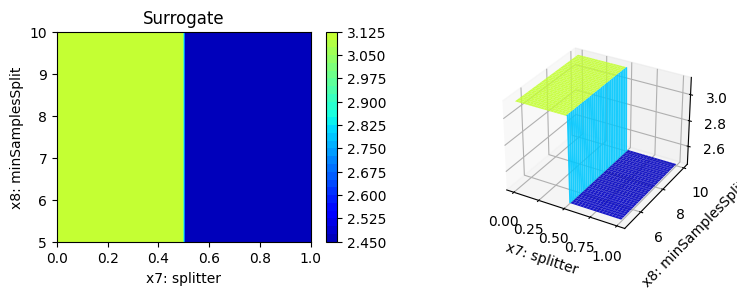

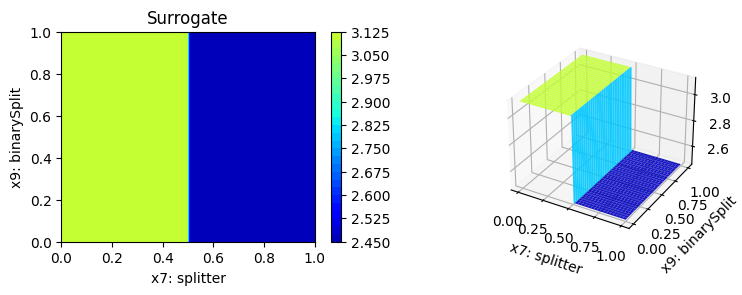

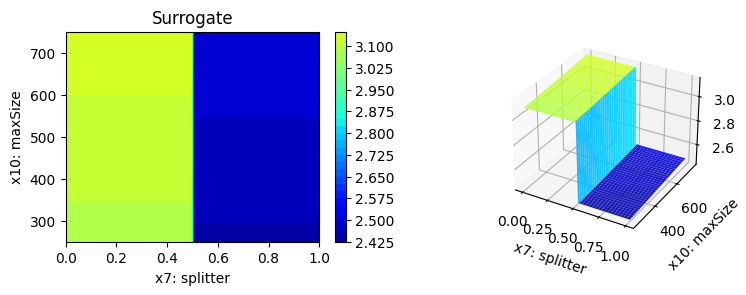

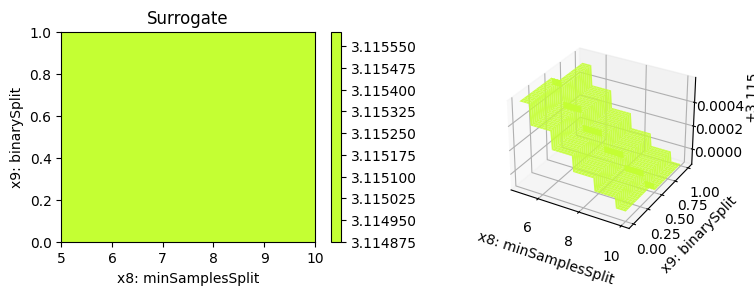

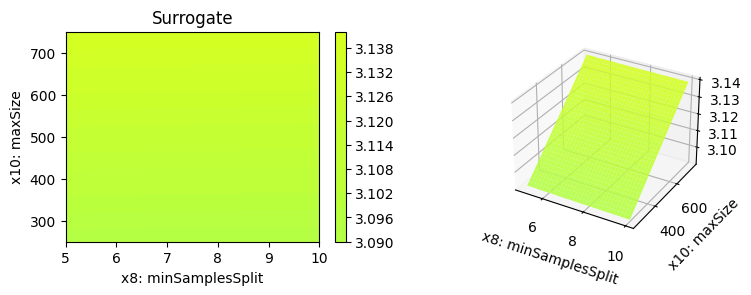

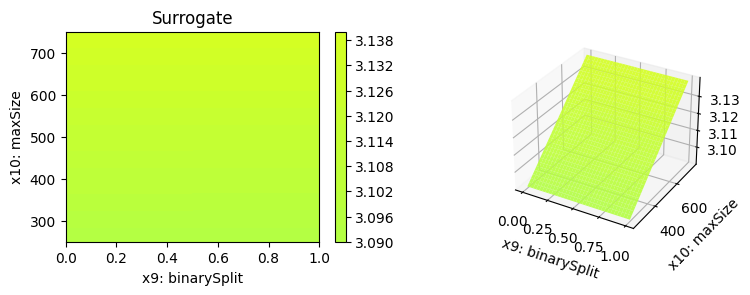

In [20]:
min(spot_htr.y), max(spot_htr.y)
n = spot_htr.k
for i in range(n-1):
    for j in range(i+1, n):
        spot_htr.plot_contour(i=i, j=j, min_z=min(spot_htr.y), max_z = max(spot_htr.y)/4 )

In [21]:
# model
# model["ts"].regressor["lm"].weights
# forecast = model.forecast(horizon=fun_control["horizon"])
# forecast
